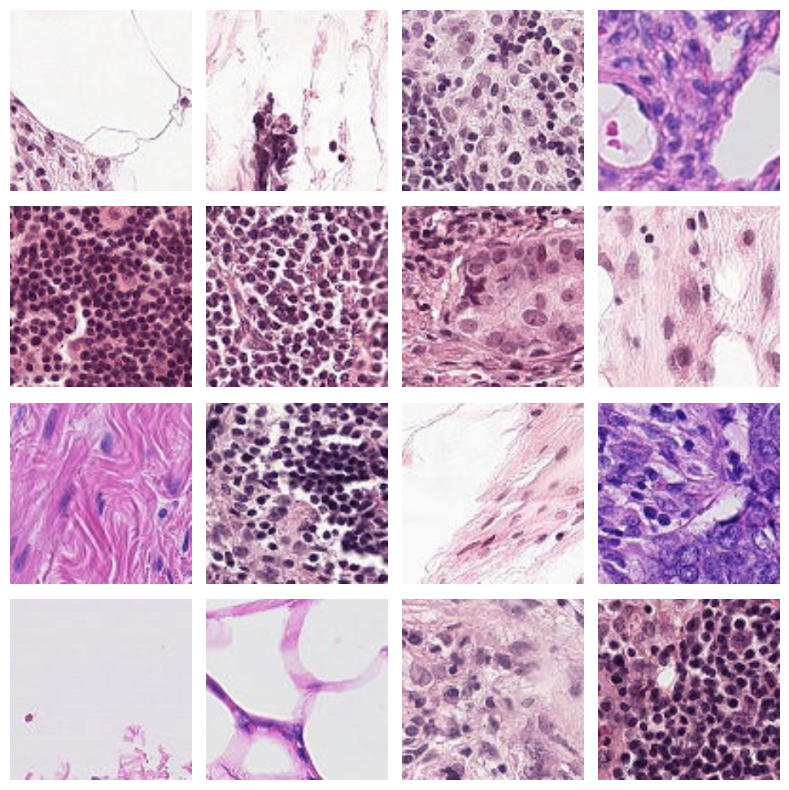

In [3]:
# trainデータセットの最初の16枚画像を表示
import matplotlib.pyplot as plt

fig, axes = plt.subplots(4, 4, figsize=(8,8))
for i in range(16):
    img, label = train_dataset[i]
    # ToTensor()で0-1化されているので、逆正規化
    img_np = img.numpy().transpose(1,2,0)
    img_np = img_np * [0.229, 0.224, 0.225] + [0.485, 0.456, 0.406]
    img_np = img_np.clip(0,1)
    ax = axes[i//4, i%4]
    ax.imshow(img_np)
    ax.axis('off')
plt.tight_layout()
plt.show()

In [1]:
# 必要なライブラリとデータセット定義
import torch
from torch.utils.data import Dataset
import pandas as pd
import os
from PIL import Image
from torchvision import transforms

DATA_DIR = './'
TRAIN_IMG_DIR = os.path.join(DATA_DIR, 'train')
LABELS_CSV = os.path.join(DATA_DIR, 'train_labels.csv')

train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

class PCamDataset(Dataset):
    def __init__(self, img_dir, labels_df, transform=None):
        self.img_dir = img_dir
        self.labels = labels_df
        self.transform = transform
    def __len__(self):
        return len(self.labels)
    def __getitem__(self, idx):
        img_id = self.labels.iloc[idx, 0]
        label = self.labels.iloc[idx, 1]
        img_path = os.path.join(self.img_dir, f"{img_id}.tif")
        image = Image.open(img_path)
        if self.transform:
            image = self.transform(image)
        return image, label

labels_df = pd.read_csv(LABELS_CSV)
train_dataset = PCamDataset(TRAIN_IMG_DIR, labels_df, train_transform)

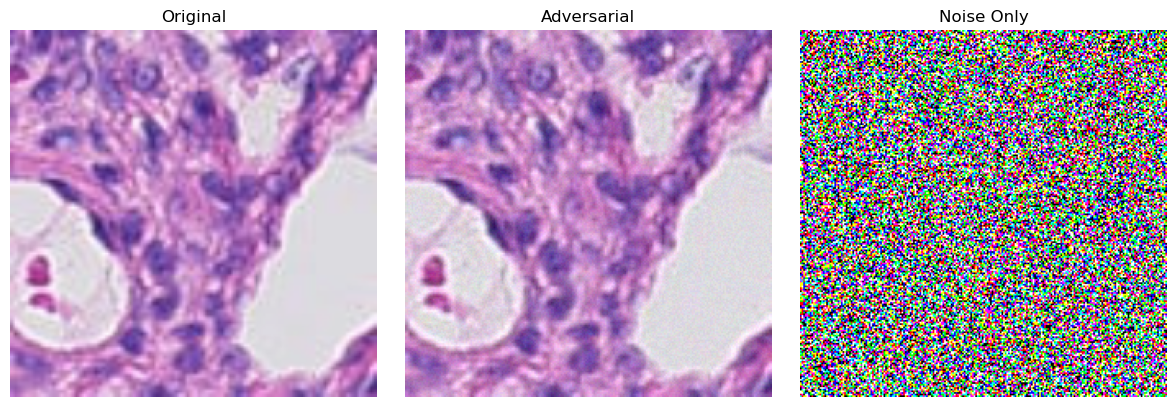

In [5]:
# FGSM（Fast Gradient Sign Method）による敵対的攻撃画像とノイズ画像の出力例
import torch
import matplotlib.pyplot as plt
import numpy as np

# 1枚目の画像を取得
img, label = train_dataset[3]
img = img.unsqueeze(0)  # バッチ次元追加
img.requires_grad = True

# 仮のモデル（ランダム重み）で出力を計算（本来は学習済みモデルを使う）
class DummyModel(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.fc = torch.nn.Linear(150528, 1)  # 224*224*3
    def forward(self, x):
        return self.fc(x.view(x.size(0), -1))
model = DummyModel()
output = model(img)
loss = torch.nn.BCEWithLogitsLoss()(output, torch.tensor([[float(label)]]))
loss.backward()

# FGSMノイズ生成
epsilon = 0.1
noise = epsilon * img.grad.data.sign()
adversarial_img = img + noise
adversarial_img = adversarial_img.squeeze().detach().numpy().transpose(1,2,0)
adversarial_img = adversarial_img * [0.229, 0.224, 0.225] + [0.485, 0.456, 0.406]
adversarial_img = adversarial_img.clip(0,1)

# ノイズ画像
noise_img = noise.squeeze().detach().numpy().transpose(1,2,0)
# ノイズを可視化しやすいように0.5で中心化
noise_img = noise_img / (2*epsilon) + 0.5
noise_img = noise_img.clip(0,1)

# 元画像
orig_img = img.squeeze().detach().numpy().transpose(1,2,0)
orig_img = orig_img * [0.229, 0.224, 0.225] + [0.485, 0.456, 0.406]
orig_img = orig_img.clip(0,1)

# 表示
plt.figure(figsize=(12,4))
plt.subplot(1,3,1)
plt.imshow(orig_img)
plt.title('Original')
plt.axis('off')
plt.subplot(1,3,2)
plt.imshow(adversarial_img)
plt.title('Adversarial')
plt.axis('off')
plt.subplot(1,3,3)
plt.imshow(noise_img)
plt.title('Noise Only')
plt.axis('off')
plt.tight_layout()
plt.show()